# Predicción de Exitus (fallecimiento). Comparativa

In [1]:
# Load Libraries
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd 
import multiprocessing
import random
from sklearn.metrics import roc_auc_score as metric




from sklearn.preprocessing import scale
from sklearn.preprocessing import OneHotEncoder
import timeit

## Dataset

Leamos el dataset a utilizar.

In [2]:
# Load the dataset 
X = pd.read_csv("../datasets/dat_sanidad.csv", sep=';', decimal=',', encoding='latin-1')
X.shape

(32706, 10)

El dataset consta de:

- 32706 **filas** o instancias
- 10 **columnas** o variables.

Veamos su contenido.

In [3]:
X.head()

,gravedad,pct_mortalidad_norma,edad_dias,numproc,potencial_ambul,proc,estancia_esperada,tipgrd,tiping,exitus
0,4,0.408730,12596,21,0,1,151,Q,1,0
1,4,0.306931,20973,22,0,1,99,Q,1,0
2,4,0.278481,19611,19,0,1,87,Q,1,0
3,3,0.150289,13583,22,0,1,100,Q,1,0
4,1,0.016573,18042,2,0,1,44,Q,1,0


- **gravedad**: Gravedad dentro del GRD. Valores de 1 a 4.

- **pct_mortalidad_norma**: Tasa de mortalidad histórica para ese GRD.
        
- **edad_dias**: Edad en días del paciente.

- **numproc**: Número de procedimientos que se han llevado a cabo al paciente a las 24 horas.
    
- **potencial_ambul**: Flag (valor 0 = no / 1 = sí) que indica si el caso se ha catalogado como potencialmente ambulatorio, es decir, no requiere ingreso.
    
- **proc**: Procedencia del paciente.

- **estancia_esperada**: Número de días que se espera que el paciente esté ingresado en el hospital por este episodio asistencial.

- **tipgrd**: GRD médico (M) o de quirófano (Q).
    
- **tiping**: Tipo de ingreso: Programado, urgente...
    
- **exitus**: 1 = El paciente falleció.

De estas variables, fecing la usaremos para realizar el split en train/validacion/test, exitus es el target y las 10 variables restantes serán el input de nuestro modelo.

## Pre-procesado

### One-Hot Encoding

Utilizaremos la técnica de one-hot encoding.

<img src="../figures/oh.png" width="50%">

Seleccionemos las variables categóricas en primer lugar.

In [4]:
categorical_vars = set(['gravedad', 'proc', 'tiping', 'tipgrd'])
numerical_vars = set(X.columns) - categorical_vars
categorical_vars = list(categorical_vars)
numerical_vars = list(numerical_vars)

In [5]:
print(categorical_vars)
print(numerical_vars)

['proc', 'gravedad', 'tiping', 'tipgrd']
['pct_mortalidad_norma', 'numproc', 'exitus', 'potencial_ambul', 'estancia_esperada', 'edad_dias']


Realizamos one hot encoding de las variables categoricas

In [6]:
ohe = OneHotEncoder(sparse = False)
ohe_fit = ohe.fit(X[categorical_vars])
X_ohe = pd.DataFrame(ohe.fit_transform(X[categorical_vars]))
X_ohe.columns = pd.DataFrame(ohe_fit.get_feature_names())


Volvemos a pegar las variables numéricas.

In [7]:
X = pd.concat((X_ohe, X[numerical_vars].reset_index()), axis=1)
del X['index']

### Tipificar

Ahora vamos a tipificar los datos, es decir, llevarlos a media 0 y desviación estándar 1.

<img src="../figures/tipify.png" width="50%">

In [8]:
y = X['exitus']
del X['exitus']

In [9]:
X_scale = pd.DataFrame(scale(X))
X_scale.columns = X.columns
X = X_scale
X.columns = X_scale.columns
print(X.head())

    (x0_1,)   (x0_2,)   (x0_3,)   (x0_4,)   (x0_6,)   (x0_7,)   (x0_8,)  \
0  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
1  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
2  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
3  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   
4  0.589002 -0.471911 -0.128712 -0.140259 -0.118114 -0.009578 -0.134718   

    (x0_9,)   (x1_1,)   (x1_2,)  ...   (x2_1,)  (x2_2,)   (x2_3,)   (x3_M,)  \
0 -0.090724 -1.322185 -0.435743  ...  0.589285  -0.5681 -0.118114 -1.554964   
1 -0.090724 -1.322185 -0.435743  ...  0.589285  -0.5681 -0.118114 -1.554964   
2 -0.090724 -1.322185 -0.435743  ...  0.589285  -0.5681 -0.118114 -1.554964   
3 -0.090724 -1.322185 -0.435743  ...  0.589285  -0.5681 -0.118114 -1.554964   
4 -0.090724  0.756324 -0.435743  ...  0.589285  -0.5681 -0.118114 -1.554964   

    (x3_Q,)  pct_mortalidad_norma   numproc  potencial_ambul  \
0  1.55496

### Split en Train/Validación/Test

Utilizaremos a modo de ejemplo los ratios habitualmente recomendados:

• Train: 70%.

• Validación: 15%.

• Test: 15%.


In [10]:
perc_values = [0.7, 0.15, 0.15];

Creamos los conjuntos de train, validacion y test con el tamaño seleccionado pero respetando el eje temporal.

In [11]:
# dimensiones de los conjuntos de train y test
n_train = int(X.shape[0] * perc_values[0])
n_val = int(X.shape[0] * perc_values[1])
n_test = int(X.shape[0] * perc_values[2])

# selección del conjunto de train
X_train = X.iloc[:n_train]
y_train = y.iloc[:n_train]

# selección del conjunto de validación
X_val = X.iloc[(n_train):(n_train+n_val)]
y_val = y.iloc[(n_train):(n_train+n_val)]

# selección del conjunto de test
X_test = X.iloc[(n_train+n_val):]
y_test = y.iloc[(n_train+n_val):]

Visualizamos el tamaño de los 3 subdatasets

In [12]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))
print('Test data size = ' + str(X_test.shape))
print('Test target size = ' + str(y_test.shape))

Train data size = (22894, 22)
Train target size = (22894,)
Validation data size = (4905, 22)
Validation target size = (4905,)
Test data size = (4907, 22)
Test target size = (4907,)


# Grid Search

Vamos a proceder a realizar un grid search que compare todos los modelos de clasificación que hemos visto, es decir:

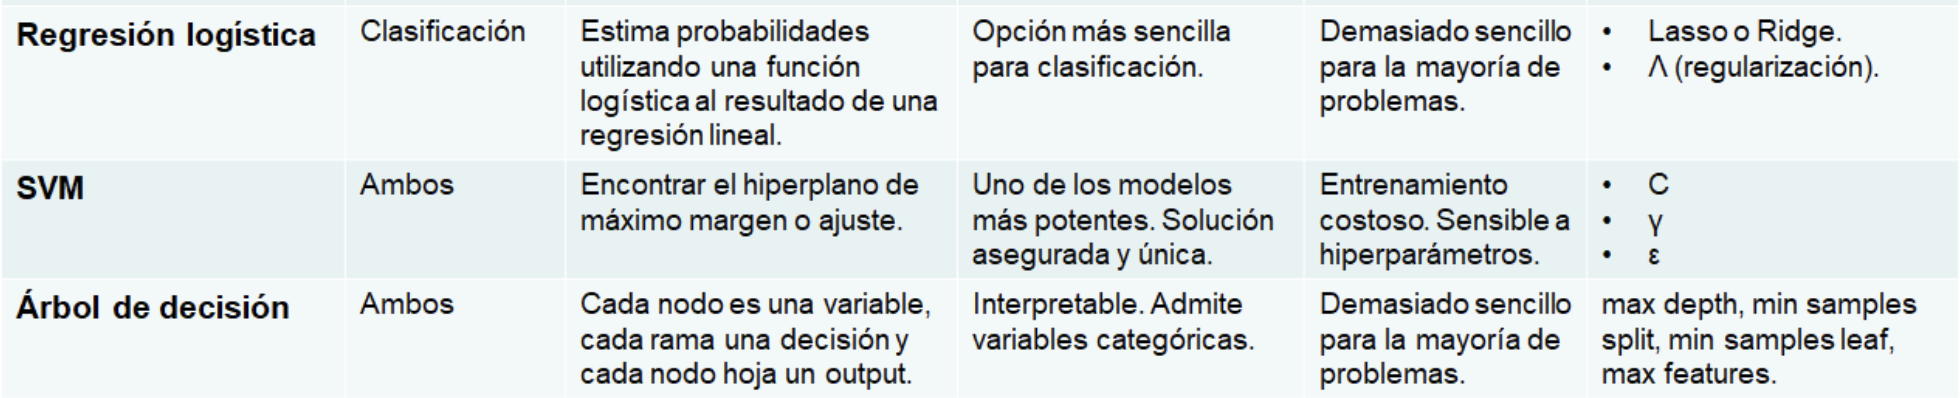

Importamos todos los modelos que vamos a usar.

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

Importamos la métrica, en este caso AUC.

In [14]:
from sklearn.metrics import roc_auc_score as metric;

Definimos algunos parámetros generales.

In [15]:
random_state = 1;
nthread = multiprocessing.cpu_count() - 1;
scale_pos_weight = sum(y_train == 0) / sum(y_train == 1);

Vamos a calcular los puntos recomendados por Cherkassky para la SVM.

In [16]:
n = X_train.shape[0];
d = X_train.shape[1];
m = np.mean(y_train);
s = np.std(y_train);
C_cherk = np.max([np.abs(m + 3*s),np.abs(m - 3*s)]);
gamma_cherk = np.power(0.2, 1/d)

Definimos el grid a llevar a cabo

In [17]:
# Regresion Logística
regularization_values = ['l1', 'l2', 'none'];
penalty_values = [1, 10, 100];

# SVM
C_values = [C_cherk, 5e-03, 4.5e-03, 4e-03];
gamma_kernel_values = [gamma_cherk, 3.26e-09, 3.255e-09, 3.25e-09];

# Arbol de Decision
max_depth_values = [None, 6, 20];
min_samples_split_values = [2, 5, 20];
min_samples_leaf_values = [1, 5, 20];
max_features_values = [None, 1, 2];

In [18]:
params_values = [{'model': 'logistic regression',
                  'regularization': regularization_values,
                 'penalty': penalty_values},
                 {'model': 'svm',
                  'C': C_values,
                 'gamma_kernel': gamma_kernel_values},
                 {'model': 'decision tree',
                 'max_depth': max_depth_values,
                 'min_samples_split': min_samples_split_values,
                 'min_samples_leaf': min_samples_leaf_values,
                 'max_features': max_features_values}]

In [19]:
total_iteraciones = 0
for params in params_values:
    if params['model'] == 'logistic regression':
        n = len(params['regularization'])*len(params['penalty'])
    elif params['model'] == 'svm':
        n = len(params['C'])*len(params['gamma_kernel'])
    elif params['model'] == 'decision tree':
        n = len(params['max_depth'])*len(params['min_samples_split'])*len(params['min_samples_leaf'])*len(params['max_features'])
    total_iteraciones = total_iteraciones + n;
    print(str(n)+ ' iteraciones de ' + str(params['model']))
print(str(total_iteraciones)+ ' iteraciones en total')        

9 iteraciones de logistic regression
16 iteraciones de svm
81 iteraciones de decision tree
106 iteraciones en total


In [20]:
grid_results = pd.DataFrame();
num_iter = 0
for params in params_values:
    
    
    # Logistic Regression
    if params['model'] == 'logistic regression':
        for regularization in params['regularization']:
            for penalty in params['penalty']:  
                start = timeit.default_timer()
                
                # Actualizar contador
                num_iter += 1; 
                
                # print control iteracion modelo
                print('Inicio de iteracion ' + str(num_iter) + 
                      '. Regularizacion = ' + str(regularization) + 
                      ', Lambda = '  + str(penalty) +
                      '\n')
                
                # Entrenar modelo
                if regularization == 'l1':
                    model = LogisticRegression(penalty = regularization, solver = 'liblinear', C = penalty, random_state = random_state)
                else:
                    model = LogisticRegression(penalty = regularization,solver = 'lbfgs', C = penalty, random_state = random_state)
               
                model.fit(X_train, np.array(y_train))

                # Generar predicciones
                pred_train_p = model.predict_proba(X_train)
                pred_val_p = model.predict_proba(X_val)

                # Calcular métricas de evaluación
                auc_train = metric(y_train, pred_train_p[:, 1])
                auc_val = metric(y_val, pred_val_p[:, 1])
                time = timeit.default_timer() - start

                print('Fin de iteracion ' + str(num_iter) + 
                     '. Regularizacion = ' + str(regularization) + 
                      ', Lambda = '  + str(penalty) +
                      '. AUC train = '  + str(auc_train) + 
                      ' -  AUC val = '  + str(auc_val)  + 
                      ' -  time = '  + str(time)  +
                      '\n')
                grid_results = grid_results.append(pd.DataFrame(data={'model':'Logistic Regression',
                                                                      'params': [{'regularization':[regularization],
                                                                                  'penalty':[penalty]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val],
                                                                      'time':[time]},
                                                               columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                   ignore_index=True)
                
     
    # SVM
    if params['model'] == 'svm':
        for C in params['C']:
            for gamma_kernel in params['gamma_kernel']:  
                start = timeit.default_timer()
                
                # Actualizar contador
                num_iter += 1; 
                
                # print control iteracion modelo
                print('Inicio de iteracion ' + str(num_iter) + 
                      '. C = ' + str(C) + 
                      ', gamma = '  + str(gamma_kernel) +
                      '\n')
                
                # Entrenar modelo               
                model = SVC(C = C, gamma = gamma_kernel, probability = True, random_state = random_state)
               
                model.fit(X_train, np.array(y_train))

                # Generar predicciones
                pred_train_p = model.predict_proba(X_train)
                pred_val_p = model.predict_proba(X_val)

                # Calcular métricas de evaluación
                auc_train = metric(y_train, pred_train_p[:, 1])
                auc_val = metric(y_val, pred_val_p[:, 1])
                time = timeit.default_timer() - start

                print('Fin de iteracion ' + str(num_iter) + 
                     '. C = ' + str(C) + 
                      ', gamma = '  + str(gamma_kernel) +
                      '. AUC train = '  + str(auc_train) + 
                      ' -  AUC val = '  + str(auc_val)  + 
                      ' -  time = '  + str(time)  +
                      '\n')
                grid_results = grid_results.append(pd.DataFrame(data={'model':'SVM',
                                                                     'params': [{'C':[C],
                                                                              'gamma_kernel':[gamma_kernel]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val],
                                                                      'time':[time]},
                                                               columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                   ignore_index=True)
                
    # Decision Tree
    if params['model'] == 'decision tree':
        for max_depth in params['max_depth']:
            for min_samples_split in params['min_samples_split']:  
                for min_samples_leaf in params['min_samples_leaf']:  
                    for max_features in params['max_features']:  
                        start = timeit.default_timer()
                
                        # Actualizar contador
                        num_iter += 1; 

                        # print control iteracion modelo
                        print('Inicio de iteracion ' + str(num_iter) + 
                              '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '\n')

                        # Entrenar modelo               
                        model = DecisionTreeClassifier(max_depth = max_depth,
                                                      min_samples_split = min_samples_split,
                                                      min_samples_leaf = min_samples_leaf,
                                                      max_features = max_features, random_state = random_state)

                        model.fit(X_train, np.array(y_train))

                        # Generar predicciones
                        pred_train_p = model.predict_proba(X_train)
                        pred_val_p = model.predict_proba(X_val)

                        # Calcular métricas de evaluación
                        auc_train = metric(y_train, pred_train_p[:, 1])
                        auc_val = metric(y_val, pred_val_p[:, 1])
                        time = timeit.default_timer() - start

                        print('Fin de iteracion ' + str(num_iter) + 
                             '. max_depth = ' + str(max_depth) + 
                              ', min_samples_split = '  + str(min_samples_split) +
                              ', min_samples_leaf = '  + str(min_samples_leaf) +
                              ', max_features = '  + str(max_features) +
                              '. AUC train = '  + str(auc_train) + 
                              ' -  AUC val = '  + str(auc_val)  + 
                              ' -  time = '  + str(time)  +
                              '\n')
                        grid_results = grid_results.append(pd.DataFrame(data={'model':'decision tree',
                                                                              'params': [{'max_depth':[max_depth],
                                                                                          'min_samples_split':[min_samples_split],
                                                                                          'min_samples_leaf':[min_samples_leaf],
                                                                                          'max_features':[max_features]}],
                                                                      'auc_train':[auc_train],
                                                                      'auc_val':[auc_val],
                                                                      'time':[time]},
                                                                       columns=['model','params', 'auc_train', 'auc_val', 'time']), 
                                                           ignore_index=True) 

Inicio de iteracion 1. Regularizacion = l1, Lambda = 1

Fin de iteracion 1. Regularizacion = l1, Lambda = 1. AUC train = 0.9405731040177965 -  AUC val = 0.9380497022446176 -  time = 0.3254616000000006

Inicio de iteracion 2. Regularizacion = l1, Lambda = 10

Fin de iteracion 2. Regularizacion = l1, Lambda = 10. AUC train = 0.9405196076694871 -  AUC val = 0.9380142006413194 -  time = 2.377927400000001

Inicio de iteracion 3. Regularizacion = l1, Lambda = 100

Fin de iteracion 3. Regularizacion = l1, Lambda = 100. AUC train = 0.9405133441814891 -  AUC val = 0.9379225836005497 -  time = 5.202646099999999

Inicio de iteracion 4. Regularizacion = l2, Lambda = 1

Fin de iteracion 4. Regularizacion = l2, Lambda = 1. AUC train = 0.9405310051640405 -  AUC val = 0.9384264773247823 -  time = 0.12100620000000006

Inicio de iteracion 5. Regularizacion = l2, Lambda = 10

Fin de iteracion 5. Regularizacion = l2, Lambda = 10. AUC train = 0.9405154491241771 -  AUC val = 0.9389509848831882 -  time = 0.1

C:\Users\jesus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\jesus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:1322: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  warnings.warn(
C:\Users\jesus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/pre

Fin de iteracion 7. Regularizacion = none, Lambda = 1. AUC train = 0.9405109825384735 -  AUC val = 0.9388811268896015 -  time = 0.12037669999999778

Inicio de iteracion 8. Regularizacion = none, Lambda = 10

Fin de iteracion 8. Regularizacion = none, Lambda = 10. AUC train = 0.9405109825384735 -  AUC val = 0.9388811268896015 -  time = 0.1147828000000004

Inicio de iteracion 9. Regularizacion = none, Lambda = 100



C:\Users\jesus\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Fin de iteracion 9. Regularizacion = none, Lambda = 100. AUC train = 0.9405109825384735 -  AUC val = 0.9388811268896015 -  time = 0.12077640000000045

Inicio de iteracion 10. C = 0.6169806179116835, gamma = 0.9294555738186685

Fin de iteracion 10. C = 0.6169806179116835, gamma = 0.9294555738186685. AUC train = 0.8880951885887463 -  AUC val = 0.7195379065506186 -  time = 27.5987037

Inicio de iteracion 11. C = 0.6169806179116835, gamma = 3.26e-09

Fin de iteracion 11. C = 0.6169806179116835, gamma = 3.26e-09. AUC train = 0.9380300252105392 -  AUC val = 0.9377565277141547 -  time = 12.319200000000002

Inicio de iteracion 12. C = 0.6169806179116835, gamma = 3.255e-09

Fin de iteracion 12. C = 0.6169806179116835, gamma = 3.255e-09. AUC train = 0.93880510618024 -  AUC val = 0.9386486486486486 -  time = 12.5181233

Inicio de iteracion 13. C = 0.6169806179116835, gamma = 3.25e-09

Fin de iteracion 13. C = 0.6169806179116835, gamma = 3.25e-09. AUC train = 0.9393458197506773 -  AUC val = 0.9387

Fin de iteracion 44. max_depth = None, min_samples_split = 20, min_samples_leaf = 1, max_features = None. AUC train = 0.9878442383483079 -  AUC val = 0.7767052221713238 -  time = 0.07158359999999675

Inicio de iteracion 45. max_depth = None, min_samples_split = 20, min_samples_leaf = 1, max_features = 1

Fin de iteracion 45. max_depth = None, min_samples_split = 20, min_samples_leaf = 1, max_features = 1. AUC train = 0.9803819341496918 -  AUC val = 0.810069285387082 -  time = 0.022964999999999236

Inicio de iteracion 46. max_depth = None, min_samples_split = 20, min_samples_leaf = 1, max_features = 2

Fin de iteracion 46. max_depth = None, min_samples_split = 20, min_samples_leaf = 1, max_features = 2. AUC train = 0.9810314886591078 -  AUC val = 0.8158188273018782 -  time = 0.0236358000000223

Inicio de iteracion 47. max_depth = None, min_samples_split = 20, min_samples_leaf = 5, max_features = None

Fin de iteracion 47. max_depth = None, min_samples_split = 20, min_samples_leaf = 5, m

Fin de iteracion 75. max_depth = 6, min_samples_split = 20, min_samples_leaf = 5, max_features = 1. AUC train = 0.8471285116283965 -  AUC val = 0.8314017407237747 -  time = 0.017070600000010927

Inicio de iteracion 76. max_depth = 6, min_samples_split = 20, min_samples_leaf = 5, max_features = 2

Fin de iteracion 76. max_depth = 6, min_samples_split = 20, min_samples_leaf = 5, max_features = 2. AUC train = 0.9252405474596551 -  AUC val = 0.915141433806688 -  time = 0.02202289999996765

Inicio de iteracion 77. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = None

Fin de iteracion 77. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = None. AUC train = 0.9519405132928415 -  AUC val = 0.9373505497022447 -  time = 0.05171649999999772

Inicio de iteracion 78. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = 1

Fin de iteracion 78. max_depth = 6, min_samples_split = 20, min_samples_leaf = 20, max_features = 1.

Fin de iteracion 104. max_depth = 20, min_samples_split = 20, min_samples_leaf = 20, max_features = None. AUC train = 0.9686876940173165 -  AUC val = 0.8797457627118643 -  time = 0.07202720000003637

Inicio de iteracion 105. max_depth = 20, min_samples_split = 20, min_samples_leaf = 20, max_features = 1

Fin de iteracion 105. max_depth = 20, min_samples_split = 20, min_samples_leaf = 20, max_features = 1. AUC train = 0.9484245915833609 -  AUC val = 0.911008932661475 -  time = 0.020070799999984956

Inicio de iteracion 106. max_depth = 20, min_samples_split = 20, min_samples_leaf = 20, max_features = 2

Fin de iteracion 106. max_depth = 20, min_samples_split = 20, min_samples_leaf = 20, max_features = 2. AUC train = 0.9511997274869319 -  AUC val = 0.8955955107650022 -  time = 0.023324399999978596



In [21]:
grid_results.groupby(['model'], sort=False)['time'].mean().sort_values()

model
decision tree           0.040924
Logistic Regression     0.955546
SVM                    16.017494
Name: time, dtype: float64

Veamos los resultados.

In [22]:
grid_results

,model,params,auc_train,auc_val,time
0,Logistic Regression,"{'regularization': ['l1'], 'penalty': [1]}",0.940573,0.938050,0.325462
1,Logistic Regression,"{'regularization': ['l1'], 'penalty': [10]}",0.940520,0.938014,2.377927
2,Logistic Regression,"{'regularization': ['l1'], 'penalty': [100]}",0.940513,0.937923,5.202646
3,Logistic Regression,"{'regularization': ['l2'], 'penalty': [1]}",0.940531,0.938426,0.121006
4,Logistic Regression,"{'regularization': ['l2'], 'penalty': [10]}",0.940515,0.938951,0.101221
...,...,...,...,...,...
101,decision tree,"{'max_depth': [20], 'min_samples_split': [20],...",0.961752,0.879096,0.024003
102,decision tree,"{'max_depth': [20], 'min_samples_split': [20],...",0.959245,0.878311,0.025915
103,decision tree,"{'max_depth': [20], 'min_samples_split': [20],...",0.968688,0.879746,0.072027
104,decision tree,"{'max_depth': [20], 'min_samples_split': [20],...",0.948425,0.911009,0.020071


Vamos a analizar el mejor resultado para cada familia de modelos.

In [23]:
grid_results.groupby(['model'], sort=False)['auc_val'].max().sort_values()

model
decision tree          0.937351
Logistic Regression    0.938951
SVM                    0.939226
Name: auc_val, dtype: float64

Nos quedamos con la mejor combinación de familia de modelos + hiperparámetros.

In [25]:
best_params = grid_results.iloc[grid_results['auc_val'].idxmax()]
best_params

model                                               SVM
params       {'C': [0.004], 'gamma_kernel': [3.26e-09]}
auc_train                                      0.937681
auc_val                                        0.939226
time                                          14.567457
Name: 22, dtype: object

Juntamos validación y train para entrenar el modelo final.

In [26]:
print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))
print('Validation data size = ' + str(X_val.shape))
print('Validation target size = ' + str(y_val.shape))

# Combinar train y validación
X_train = pd.concat((X_train,X_val), axis = 0)
y_train = np.concatenate((y_train, y_val), axis = 0)

del X_val, y_val

print('Train data size = ' + str(X_train.shape))
print('Train target size = ' + str(y_train.shape))

Train data size = (22894, 22)
Train target size = (22894,)
Validation data size = (4905, 22)
Validation target size = (4905,)
Train data size = (27799, 22)
Train target size = (27799,)


Y ahora entrenamos el modelo final.

In [27]:
# Logistic Regression
if best_params['model'] == 'logistic regression':       

    # Entrenar modelo
    if best_params['params']['regularization'] == 'l1':
        model = LogisticRegression(penalty = best_params['params']['regularization'][0], solver = 'liblinear', C = best_params['params']['penalty'][0], random_state = random_state)
    else:
        model = LogisticRegression(penalty = best_params['params']['regularization'][0],solver = 'lbfgs', C = best_params['params']['penalty'][0], random_state = random_state)


# SVM
elif best_params['model'] == 'SVM':

    model = SVC(C = best_params['params']['C'][0], gamma = best_params['params']['gamma_kernel'][0], probability = True, 
                random_state = random_state)             


# Decision Tree
elif best_params['model'] == 'decision tree':
    model = DecisionTreeClassifier(max_depth = int(best_params['params']['max_depth'][0]),
                                                  min_samples_split = int(best_params['params']['min_samples_split'][0]),
                                                  min_samples_leaf = int(best_params['params']['min_samples_leaf'][0]),
                                                  max_features = int(best_params['params']['max_features'][0]), 
                                   random_state = random_state)


# Entrenar modelo
model.fit(X_train, np.array(y_train))

# Generar predicciones
pred_train_p = model.predict_proba(X_train)
pred_test_p = model.predict_proba(X_test)

# Calcular métricas de evaluación
auc_train = metric(y_train, pred_train_p[:, 1])
auc_test = metric(y_test, pred_test_p[:, 1]) 

results = pd.DataFrame()
results = results.append(pd.DataFrame(data={'model':best_params['model'],'auc_train':[auc_train],'auc_test':[auc_test]}, columns=['model',  'auc_train', 'auc_test']), ignore_index=True)

In [28]:
results

,model,auc_train,auc_test
0,SVM,0.939131,0.920528
